In [1]:
import numpy as np

class KNN:
    """This class is the parent class of the KNNClassifier and
    KNNRegresser classes."""
    
    def __init__(self, k, weights="uniform"):
        
        # Check that k is a positive integer.
        assert (type(k) == int) & (k > 0), "k should be a positive integer."
        # Check that weights is either 'uniform' or 'distance'.
        assert ((weights == "uniform") 
                | (weights == "distance")), "weights should be 'uniform' or 'distance'."
        
        # Initialize the k, which is the number of nearest neighbors.
        self.k = k
        # Initialize the type of weighting of the data points ("uniform", 
        # or "distance").
        self.weights = weights
        # Initialize the X and y attributes with None.
        self._X = None
        self._y = None
        
    def fit(self, X, y):
        """This method saves the training data so it can be used to make 
        predictions for new data."""
        
        # Check that X and y are numpy arrays.
        assert ((type(X) == np.ndarray) 
                & (type(y) == np.ndarray)), "X and y must by numpy arrays."
        # Check that X is a 2-D array with at least 1 column.
        assert len(X.shape) == 2, "X must by an n by m array, where m >= 1."
        # Check that y is a 1-D array.
        assert len(y.shape) == 1, "y must be a 1-D array"
        # Check that the number of rows in X matches elements in y.
        assert y.shape[0] == X.shape[0], "X must have as many rows as y has elements."
        
        self._X = X
        self._y = y.astype('object')
        
        return
    
    def _euclidean_distances(self, array, k_nearest_indices=None):
        """This method calculates the Euclidean distance between an array
        and the data points in a matrix."""
        
        # If an array of indices is not passed, calculate the Euclidean
        # distance between the input array and the entire training data
        # set.
        if type(k_nearest_indices) == type(None):
            euclidean_distances = np.sqrt(np.sum((self._X-array)**2, 
                                                 axis=-1))
        # If an array of the indicies of the k nearest data points is passed
        # to the method from the _predict_one method, calculate the Euclidean 
        # distances of the k nearest points.
        else:
            euclidean_distances = np.sqrt(np.sum((self._X[k_nearest_indices]
                                                  -array)**2, 
                                                 axis=-1))
        # Return the Euclidean distances of the array from the data points.
        return euclidean_distances
    
    def _k_nearest_indices(self, array):
        """This method takes in an array and finds the indices of the k 
        nearest data points in the training data."""
        
        # Calculate the Euclidean distances between the new data point and 
        # the training data.
        euclidean_distances = self._euclidean_distances(array)
        # Sort the indices from smallest Euclidean distance from the new
        # data point to the largest.
        sorted_indices = np.argsort(euclidean_distances, 
                                    axis=None, 
                                    kind="quicksort")
        # Save the indices of the k nearest points.
        k_nearest_indices = sorted_indices[0:self.k]
        # Return the indicies of the k nearest points.
        return k_nearest_indices
    
    def _predict_one(self, array):
        """This method will be overwritten in the child classes. It predicts
        the label for a single observation. In the predict method, it will 
        be applied to each row of the array to predict for multiple
        observations."""
        
        return
    
    def predict(self, array, smoothing=0, probability=False):
        """This method predicts the label for each row in an array of new
        observations by applying the _predict_one method to each row. The
        smoothing factor is set to 0, but can be increased if divide by 0
        warnings are encountered. The probability argument is only used
        if passed as true to the KNNClassifier class."""
        
        # If there is only one observation in the new array, use the
        # _predict_one method to calculate a prediction.
        if len(self._X[0].shape) == len(array.shape):
            predictions = self._predict_one(array, 
                                            smoothing=smoothing,
                                            probability=probability)
        
        else:
            # Check that the input array has the same number of columns as X.
            assert array.shape[1] == self._X.shape[1], ("Input array must have ",
                                                        "the same number of columns ", 
                                                        "as X.")
            # Check that the smoothing factor is non-negative.
            assert smoothing >= 0, "smoothing factor must be non-negative."
            
            # Apply the _predict_one method to each row in the input array.
            predictions = np.apply_along_axis(self._predict_one,
                                              axis=1, 
                                              arr=array, 
                                              smoothing=smoothing,
                                              probability=probability)
        # Return the predictions.
        return predictions


class KNNClassifier(KNN):
    """This class is the child class of the KNN class that is performs
    KNN classification."""
    
    def _predict_one(self, array, smoothing, probability):
        """This method predicts the label for a single observation and
        is applied to the rows of an input array in the predict method
        to predict multiple observations."""
        
        # Retrieve the indices of the k nearest observations to the new
        # data point.
        k_nearest_indices = self._k_nearest_indices(array)
        # Retrieve the labels of the k nearest observations to the new
        # data point.
        k_nearest_labels = self._y[k_nearest_indices]
        
        # If using uniform weighting, create a weight array of k ones. 
        if self.weights == "uniform":
            my_weights = np.repeat(1, repeats=self.k)
            
        # If using inverse distance weighting...    
        else:
            # Retrieve the sorted Euclidean distances of the k nearest points.
            k_nearest_distances = self._euclidean_distances(array,
                                                            k_nearest_indices=k_nearest_indices)
            # Set the weights for the training labels equal to the inverse 
            # of their features' Euclidean distance from the new data point.
            my_weights = 1 / (k_nearest_distances + smoothing)
            
        # Get the unique labels in the k nearest points.
        label_set = np.unique(k_nearest_labels)
        # Create an empty list to hold the weighted vote tallys
        weighted_vote_tally = []
        # Create a dictionary to hold the probabilities of belonging to each class.
        prob_dict = dict()
        
        # For each label in the k nearest points...
        for label in label_set:
            # Create a binary mask to select the weights associated with the label.
            temp_indexes = k_nearest_labels==label
            # Sum the weights associated with the label and append it to the list.
            weighted_vote = np.sum(my_weights[temp_indexes])
            weighted_vote_tally.append(weighted_vote)
            # Create a key from the label and make the value the weighted vote share.
            prob_dict[label] = weighted_vote / np.sum(my_weights)
        
        # Find the index of highest number of votes in weighted_vote_tally.
        most_likely_class_index = np.argmax(weighted_vote_tally)
        # Use that index to grab the label with the highest vote share.
        label = label_set[most_likely_class_index]
        
        # If the user wants probabilities, return the dictionary.
        if probability == True:
            return prob_dict
        # If the user doesn't want predicted classes, return the predicted label.
        else:
            # Return the label.
            return label

    
class KNNRegresser(KNN):
    """This class is the child class of the KNN class that is performs
    KNN regression."""
    
    def _predict_one(self, array, smoothing, probability):
        """This method predicts the label for a single observation and
        is applied to the rows of an input array in the predict method
        to predict multiple observations. The probability argument has 
        nothing to do with the KNNRegresser. It is only included to 
        allow the KNN parent class to have a predict method that can
        be used with the two child classes, making maintenance easier."""
        
        # Retrieve the indices of the k nearest observations to the new
        # data point.
        k_nearest_indices = self._k_nearest_indices(array)
        # Retrieve the labels of the k nearest observations to the new
        # data point.
        k_nearest_labels = self._y[k_nearest_indices]
        
        # If using uniform weighting, create a weight array of k ones. 
        if self.weights == "uniform":
            my_weights = np.repeat(1, repeats=self.k)
        # If using inverse distance weighting...
        else:
            # Retrieve the sorted Euclidean distances of the k nearest points.
            k_nearest_distances = self._euclidean_distances(array,
                                                            k_nearest_indices=k_nearest_indices)
            # Set the weights for the training labels equal to the inverse 
            # of their features' Euclidean distance from the new data point.
            my_weights = 1 / (k_nearest_distances + smoothing)
        
        # Multiply the weights by their associated labels, sum the products
        # and divide by the sum of the weights.
        label = np.matmul(my_weights, k_nearest_labels) / np.sum(my_weights)
        
        # Return the label.
        return label

# Classification Demonstration

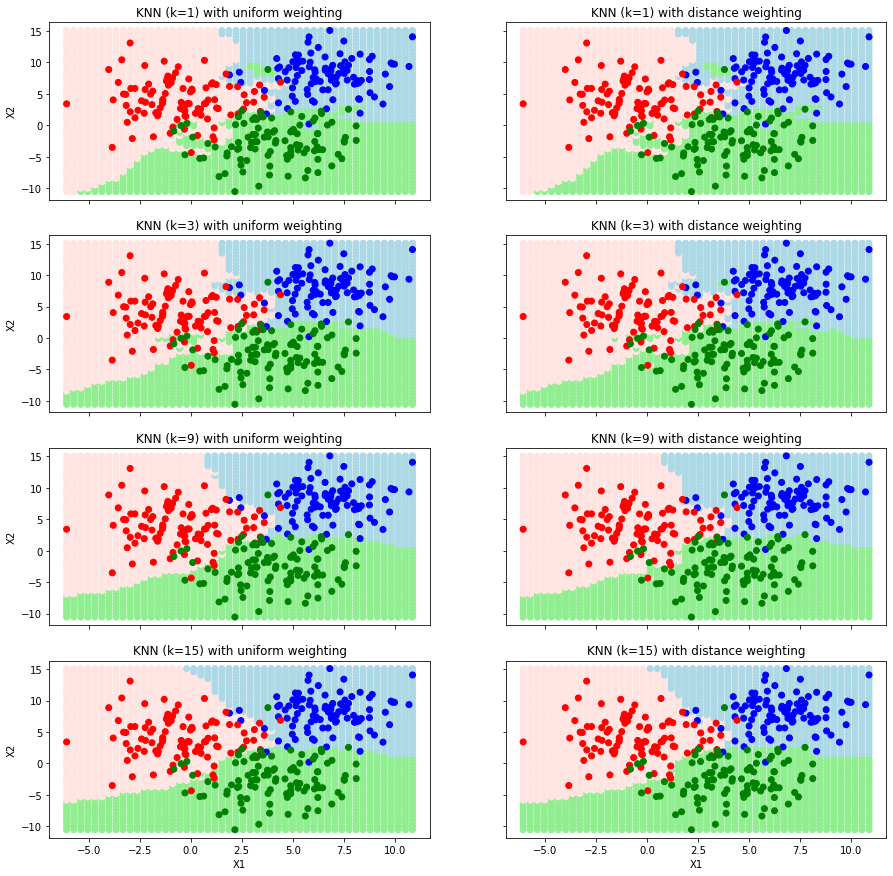

In [2]:
import matplotlib.pyplot as plt

# Set a random seed for reproducibility.
np.random.seed(1)

# Set the number of data points in each class.
size = 100
# Create the 3 bivariate normal distributions that will belong to 1 of 3
# classes.
X_1 = np.transpose(np.array([np.random.normal(loc=6.5, scale=2, size=size),
                             np.random.normal(loc=7.5, scale=3, size=size)]))
               
X_2 = np.transpose(np.array([np.random.normal(loc=-0.5, scale=2, size=size),
                             np.random.normal(loc=4, scale=3, size=size)]))

X_3 = np.transpose(np.array([np.random.normal(loc=4, scale=2, size=size),
                             np.random.normal(loc=-3, scale=3, size=size)]))
# Combine them into a single numpy array.
X = np.append(X_1, X_2, axis=0)
X = np.append(X, X_3, axis=0)
# Forget them to free memory.
del X_1
del X_2 
del X_3

# Create labels for each of the 3 classes.
y_1 = np.repeat(1, repeats=size)
y_2 = np.repeat(2, repeats=size)
y_3 = np.repeat(3, repeats=size)
# Append them all into 1 array.
y = np.append(y_1, y_2)
y = np.append(y, y_3)
# Forget them to free memory.
del y_1
del y_2 
del y_3

# Create arrays with 50 equidistant points along each dimension of the feature
# space.
detail = 50
x_1 = np.linspace(np.min(np.transpose(X)[0]), np.max(np.transpose(X)[0]), detail)
x_2 = np.linspace(np.min(np.transpose(X)[1]), np.max(np.transpose(X)[1]), detail)

# Create pairs of values covering the feature space and append them to a list.
feature_space = []
for i in x_1:
    for j in x_2:
        feature_space.append((i, j))
# Convert the list to a numpy array.       
feature_space = np.array(feature_space)

# Create a dictionary to map point labels to colors.
point_color_dict = {1: "blue",
                    2: "red",
                    3: "green"}
# Create a dictionary to map decision space labels to colors.
background_color_dict = {1: "lightblue",
                         2: "mistyrose",
                         3: "lightgreen"}

# Map classes to colors for the scatter plot.
point_colors = [point_color_dict[y_i] for y_i in y]

# Create a dictionary to hold the hyperparamters and color codings
# of multiple KNN Classifiers
decision_space_dict = dict()
# Create a key that will increase by 1 after each model
key_counter = 0
# Create a list of k values to try.
ks_to_try = [1, 3, 9, 15]
# For each k in k values to try...
for k in ks_to_try:
    # For each weight...
    for weights in ["uniform", "distance"]:
        # Instantiate a temporary KNNClassifer object with the k and weight.
        temp_knn = KNNClassifier(k=k, weights=weights)
        # "Fit" it to the data.
        temp_knn.fit(X, y)
        # Get predicted classes of each point in the feature space.
        temp_preds = temp_knn.predict(feature_space)
        # Store a tuple of the hyperparameters and feature space color labels in
        # the dictionary.
        decision_space_dict[key_counter] = [(str(k), weights), 
                                            [background_color_dict[y_i] for y_i in temp_preds]]
        # Increment the key by 1.
        key_counter += 1

nrows, ncols = len(ks_to_try), 2
fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))

key_counter = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].scatter(np.transpose(feature_space)[0], np.transpose(feature_space)[1], 
                          color=decision_space_dict[key_counter][1])
        axs[i, j].scatter(np.transpose(X)[0], np.transpose(X)[1], color=point_colors)
        axs[i, j].set_title(f"KNN (k={decision_space_dict[key_counter][0][0]}) with {decision_space_dict[key_counter][0][1]} weighting")
        key_counter += 1

for ax in axs.flat:
    ax.set(xlabel='X1', ylabel='X2')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [3]:
random_indices = np.int32(np.random.uniform(0, X.shape[0]-1, size=5))
temp_knn.predict(X[random_indices], smoothing=0.1, probability=True)

array([{2: 1.0}, {1: 1.0}, {1: 1.0},
       {1: 0.45991927628302215, 3: 0.5400807237169778},
       {1: 0.08869939992410657, 2: 0.9113006000758936}], dtype=object)

# Regression Demonstration

## Non-Linear Function with Many Observations

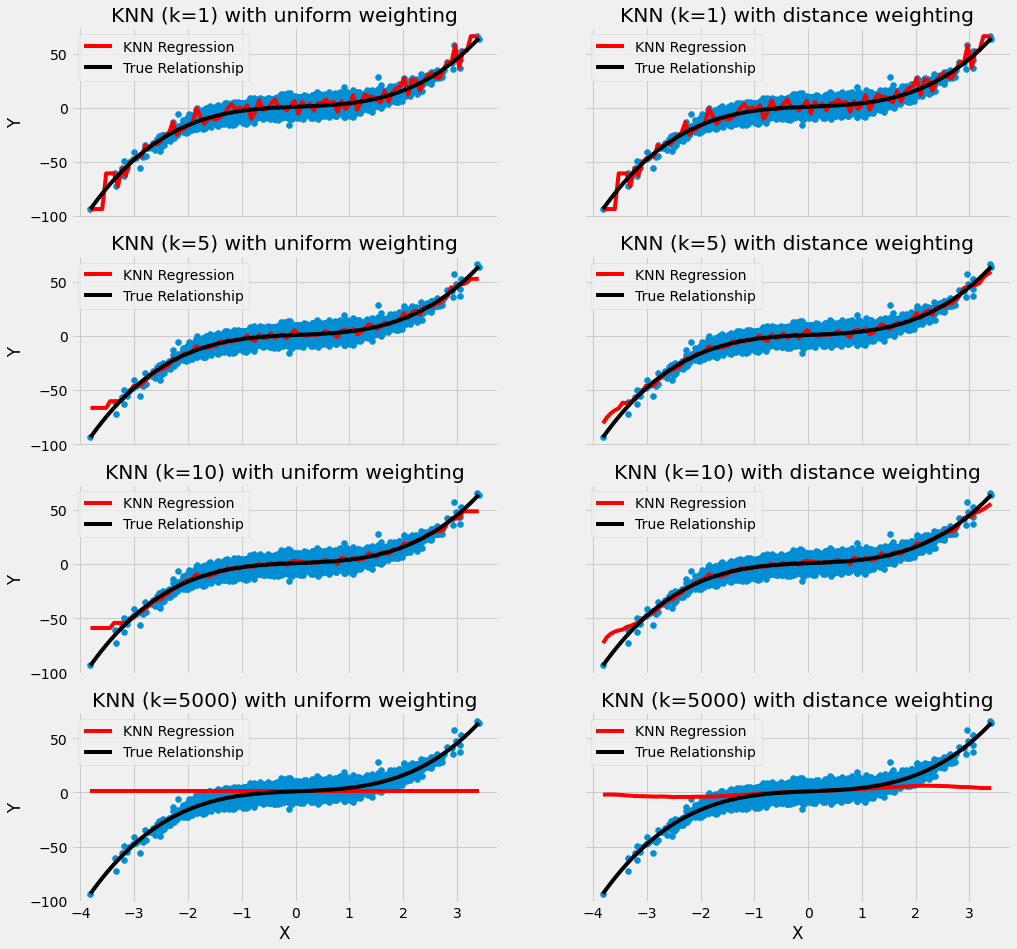

In [4]:
def population_curve(x):
    """This function defines the true relationship
    between x and y and is a cubic function."""
    return  1 + 2*x - 0.25*x**2 + 1.5*x**3

# Set the number of datapoints to generate.
size = 5000
# Generate a sample from a Standard Normal Distribution.
X = np.random.normal(loc=0, scale=1, size=size)
# Generate corresponding y values with some normal random error
# added.
y = population_curve(X) + np.random.normal(loc=0, scale=4, size=size)
# Reshape X to be a column vector.
X = X.reshape(-1,1)

# Create 100 equidistant point between the minimum and maximum value of
x_space = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
true_y = [population_curve(x) for x in x_space.flatten()]

# Create a dictionary to hold the hyperparamters and color codings
# of multiple KNN Regressers.
prediction_dict = dict()
# Create a key that will increase by 1 after each model
key_counter = 0
# Create a list of k values to try.
ks_to_try = [1, 5, 10, size]
# For each k in k values to try...
for k in ks_to_try:
    # For each weight...
    for weights in ["uniform", "distance"]:
        # Instantiate a temporary KNNClassifer object with the k and weight.
        temp_knn = KNNRegresser(k=k, weights=weights)
        # "Fit" it to the data.
        temp_knn.fit(X, y)
        # Get predicted classes of each point in the feature space.
        temp_preds = temp_knn.predict(x_space, smoothing=0.1)
        # Store a tuple of the hyperparameters and feature space color labels in
        # the dictionary.
        prediction_dict[key_counter] = [(str(k), weights), 
                                        temp_preds]
        # Increment the key by 1.
        key_counter += 1

nrows, ncols = len(ks_to_try), 2

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))

key_counter = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].scatter(X, y)
        axs[i, j].plot(x_space, prediction_dict[key_counter][1], 
                       color="red", label="KNN Regression")
        axs[i, j].plot(x_space, true_y, 
                       color="black", label="True Relationship")
        axs[i, j].set_title(f"KNN (k={prediction_dict[key_counter][0][0]}) with {prediction_dict[key_counter][0][1]} weighting")
        axs[i, j].legend()
        key_counter += 1

for ax in axs.flat:
    ax.set(xlabel='X', ylabel='Y')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Linear Function with Few Observations

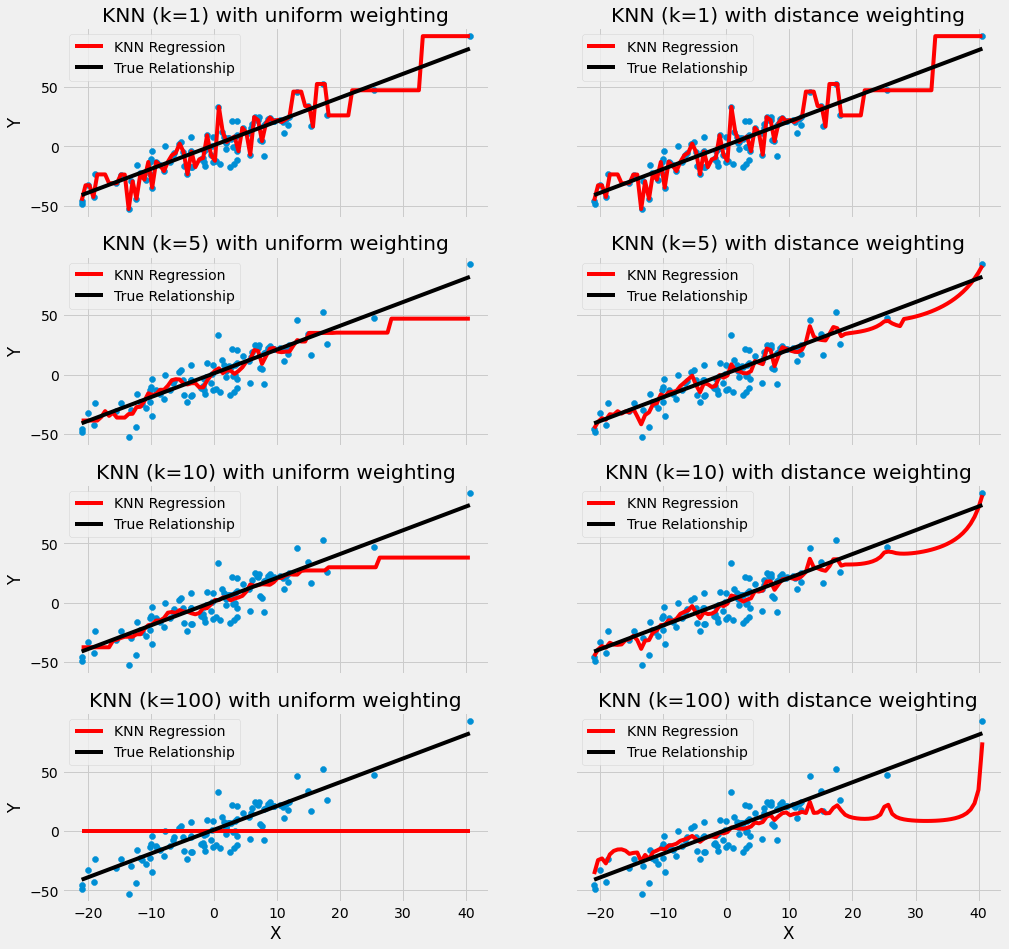

In [5]:
def population_curve(x):
    """This function defines the true relationship
    between x and y and is a cubic function."""
    return  1 + 2*x

# Set the number of datapoints to generate.
size = 100
# Generate a sample from a Standard Normal Distribution.
X = np.random.normal(loc=0, scale=10, size=size)
# Generate corresponding y values with some normal random error
# added.
y = population_curve(X) + np.random.normal(loc=0, scale=10, size=size)
# Reshape X to be a column vector.
X = X.reshape(-1,1)

# Create 100 equidistant point between the minimum and maximum value of
x_space = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
true_y = [population_curve(x) for x in x_space.flatten()]

# Create a dictionary to hold the hyperparamters and color codings
# of multiple KNN Regressers.
prediction_dict = dict()
# Create a key that will increase by 1 after each model
key_counter = 0
# Create a list of k values to try.
ks_to_try = [1, 5, 10, size]
# For each k in k values to try...
for k in ks_to_try:
    # For each weight...
    for weights in ["uniform", "distance"]:
        # Instantiate a temporary KNNClassifer object with the k and weight.
        temp_knn = KNNRegresser(k=k, weights=weights)
        # "Fit" it to the data.
        temp_knn.fit(X, y)
        # Get predicted classes of each point in the feature space.
        temp_preds = temp_knn.predict(x_space, smoothing=0.1)
        # Store a tuple of the hyperparameters and feature space color labels in
        # the dictionary.
        prediction_dict[key_counter] = [(str(k), weights), 
                                        temp_preds]
        # Increment the key by 1.
        key_counter += 1

nrows, ncols = len(ks_to_try), 2
fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))

key_counter = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].scatter(X, y)
        axs[i, j].plot(x_space, prediction_dict[key_counter][1], 
                       color="red", label="KNN Regression")
        axs[i, j].plot(x_space, true_y, 
                       color="black", label="True Relationship")
        axs[i, j].set_title(f"KNN (k={prediction_dict[key_counter][0][0]}) with {prediction_dict[key_counter][0][1]} weighting")
        axs[i, j].legend()
        key_counter += 1

for ax in axs.flat:
    ax.set(xlabel='X', ylabel='Y')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()